In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import cv2
import numpy as np


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Opencv version:",cv2.__version__)
print(f"Using device: {device}")

/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Opencv version: 4.10.0
Using device: mps


## Lets capture a photo for ourselves

In [2]:
# import time
# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Error: Could not open the camera.")
#     exit()
# time.sleep(2)
# ret, frame = cap.read()
# if ret:
#     # Save the photo to a file without showing a window
#     photo_path = "captured_photo.jpg"
#     cv2.imwrite(photo_path, frame)
#     print(f"Photo saved as {photo_path}")
# else:
#     print("Error: Could not capture a frame.")
# cap.release()

### Use YOLO model to detect a person and crop the person

/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/ultralytics/nn/tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, ma

image 1/1 /Users/wenbo/OntarioTech/CSCI 4052U Machine Learning 2/HandsOn-from-basic-encoder_decoder-to-stable-diffusion/captured_photo.jpg: 384x640 1 person, 50.7ms
Speed: 3.8ms preprocess, 50.7ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)
Detected a person at [[     560.13      323.29      1544.6      1072.8]]


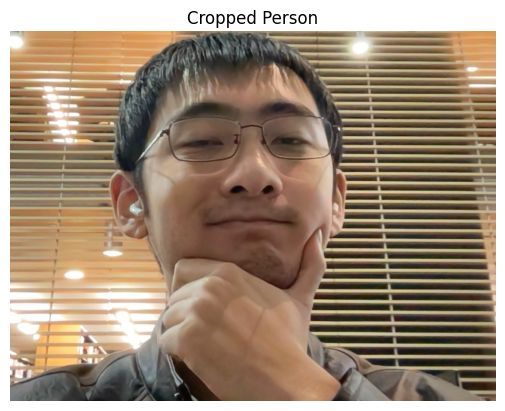

Cropped image saved at cropped_person.jpg


In [3]:
from ultralytics import YOLO
# Load a pretrained YOLO model (recommended for training)
yolo_model = YOLO("yolov8n.pt")
# Path to your image
image_path = 'captured_photo.jpg'
# Perform person detection
results = yolo_model(image_path)

image_orig = cv2.imread(image_path)
# Convert the image from BGR to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
# Display and save results
for result in results:
    # Boxes contain coordinates for detected objects
    boxes = result.boxes
    for box in boxes:
        if box.cls == 0:  # Class ID for 'person' in COCO dataset
            print(f"Detected a person at {box.xyxy.numpy()}")  # Bounding box coordinates
            bbox = box.xyxy[0].numpy()
            bbox = [int(coord) for coord in bbox]
            cropped_image = image_rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            
            # Display the cropped image using matplotlib
            plt.imshow(cropped_image)
            plt.axis('off')  # Hide axis
            plt.title("Cropped Person")
            plt.show()
            
            # Save the cropped image if needed
            cropped_image_path = "cropped_person.jpg"
            cropped_image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
            cv2.imwrite(cropped_image_path, cropped_image_bgr)
            print(f"Cropped image saved at {cropped_image_path}")


## Add Noise

In [4]:
# Read cropped image

image_orig = cv2.imread("cropped_person.jpg")
image_rgb = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)

## Define add noise Function

In [5]:
def add_noise(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Adjust shape for batch processing
    noised_img = x * (1 - amount) + noise * amount
    return noised_img, noise

/var/folders/pm/x83zrlkn551fhsmr72ncx8yw0000gn/T/ipykernel_25702/867354943.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  image_batch = torch.tensor([image_rgb for i in range(0,8)])
/var/folders/pm/x83zrlkn551fhsmr72ncx8yw0000gn/T/ipykernel_25702/867354943.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_batch = torch.tensor(image_batch, dtype=torch.float32) / 255.0


Amount noise added to the oroginal picture: tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])
torch.Size([8, 749, 984, 3])


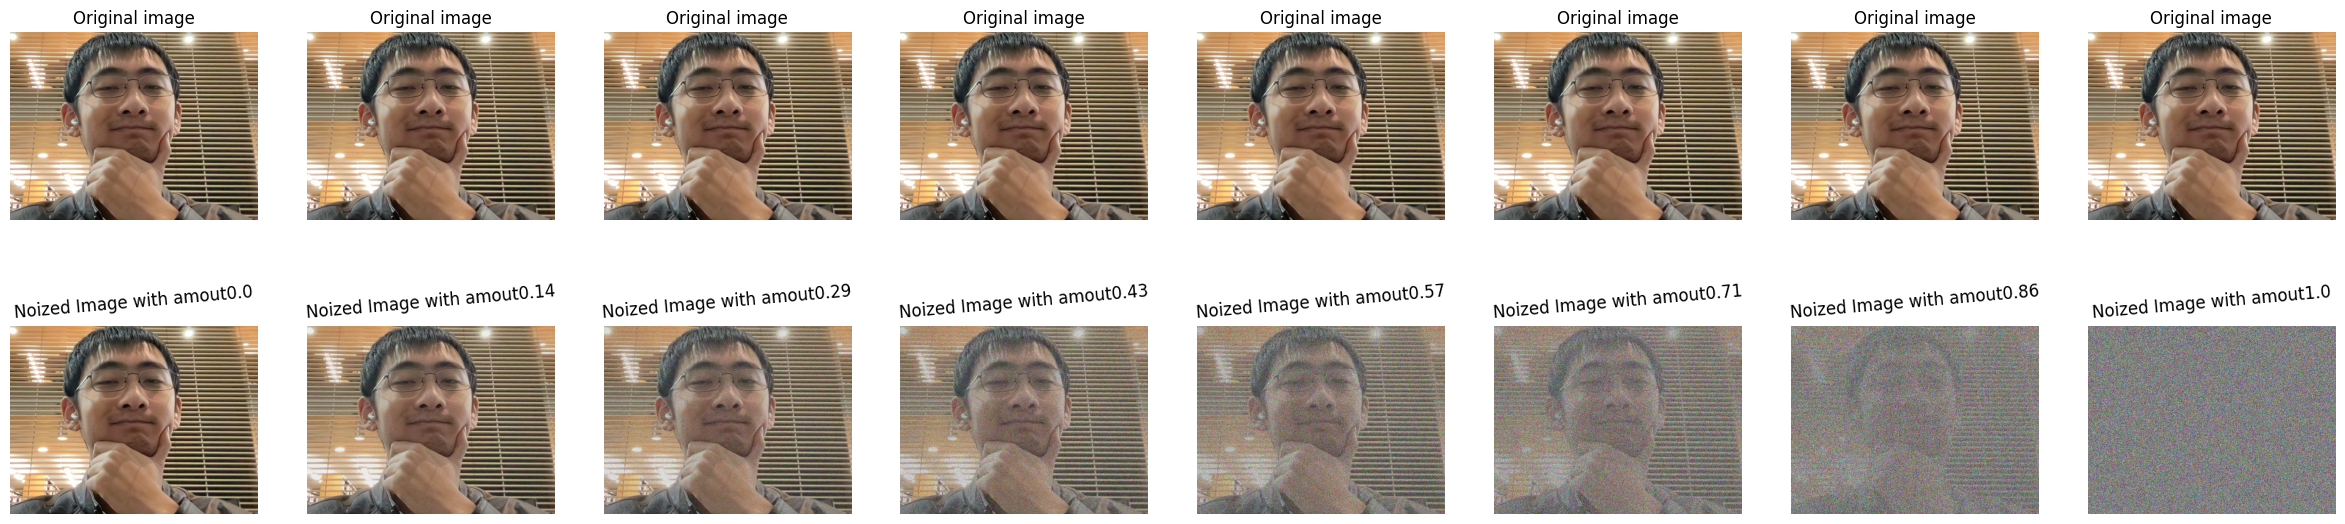

In [6]:
image_batch = torch.tensor([image_rgb for i in range(0,8)])
image_batch = torch.tensor(image_batch, dtype=torch.float32) / 255.0

amount = torch.linspace(0, 1, image_batch.shape[0])  # Left to right -> more corruption
print("Amount noise added to the oroginal picture:", amount)
print(image_batch.shape)

noised_img, noise = add_noise(image_batch, amount)

plt.figure(figsize=(30, 7))
for i in range(0, 16):
    plt.subplot(2, 8, i+1)
    if i < 8:
        plt.imshow(image_batch[i])
        plt.title("Original image")
        plt.axis('off')
    else:
        plt.imshow(noised_img[i-8])
        plt.title("Noized Image with amout" + str(round(amount[i-8].item(), 2)), rotation=5)
        plt.axis('off')

plt.show()

## Denoise

In [7]:
def denoise(corrupted_x, amount, noise):
    """Reconstruct the original input `x` from the corrupted version"""
    amount = amount.view(-1, 1, 1, 1)  # Adjust shape for batch processing
    original_x = (corrupted_x - noise * amount) / (1 - amount)
    return original_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


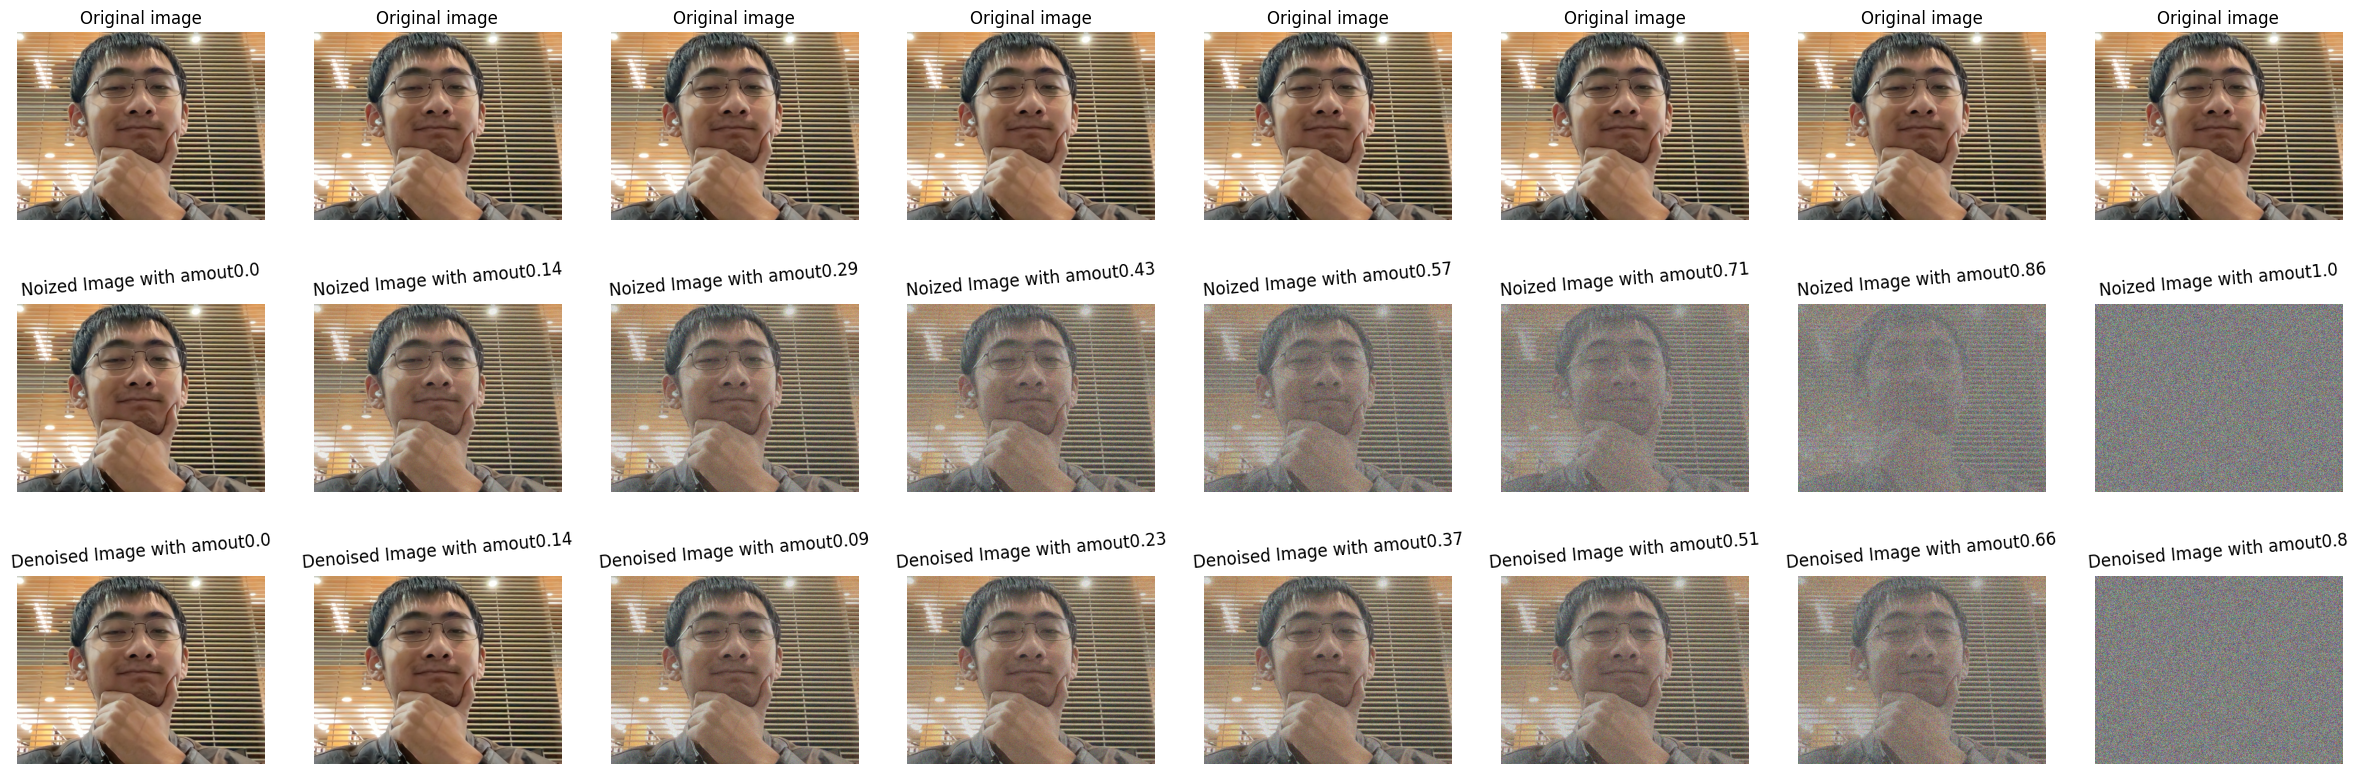

In [8]:
updated_amount = torch.where(amount >= 0.2, amount - 0.2, amount)
denoised_img = denoise(noised_img, updated_amount, noise)

plt.figure(figsize=(30, 10))
for i in range(0, 24):
    plt.subplot(3, 8, i+1)
    if i < 8:
        plt.imshow(image_batch[i])
        plt.title("Original image")
        plt.axis('off')
    elif i >=8 and i < 16:
        plt.imshow(noised_img[i-8])
        plt.title("Noized Image with amout" + str(round(amount[i-8].item(), 2)), rotation=5)
        plt.axis('off')
    else:
        plt.imshow(denoised_img[i-16])
        plt.title("Denoised Image with amout" + str(round(updated_amount[i-16].item(), 2)), rotation=5)
        plt.axis('off')

# Now Lets Scale it up to basic encoder and decoder network

MNIST

In [9]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([6, 1, 3, 3, 9, 9, 9, 9])


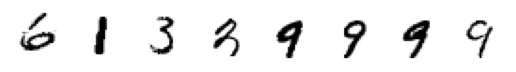

In [10]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)


images = x.squeeze(1)  # Shape becomes [8, 28, 28]
# Plot each image
batch_size = images.shape[0]
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(images[i].cpu().numpy(), cmap="Greys")  # Convert to numpy and specify grayscale
    plt.axis('off')  # Optional: Turn off axis for cleaner display

# plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [11]:
def add_noise(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

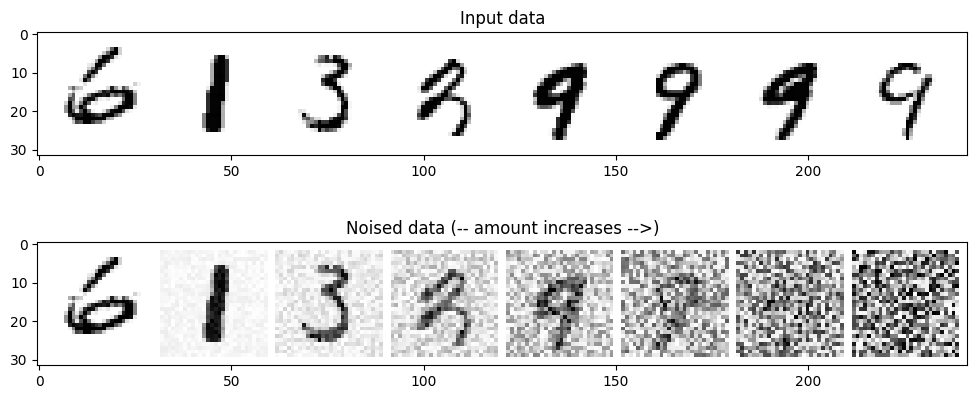

In [12]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = add_noise(x, amount)

# Plotting the noised version
axs[1].set_title("Noised data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")